# Workshop right. - Emanuele Pepe
### Predict emissions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [2]:
from scipy import stats

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

## Load data

In [3]:
#col_names = ['revenue','emissions','emp_count','sector','country']
data = pd.read_csv('./data/Workshop Data - Data Team.txt',sep='\t',header='infer')#,names=col_names)
data.head()

,revenue,emission,employee_count,sector,country
0,2264.620046,3.824741e+07,1721,energy,CountryA
1,4289.369885,5.501518e+07,3850,energy,CountryB
2,3677.948506,3.731858e+07,1456,energy,CountryB
3,3710.896732,4.768847e+07,1039,energy,CountryC
4,5326.161066,2.741059e+07,949,energy,CountryB


## Data exploration


In [4]:
data.isna().values.any()

False

No explicitly missing data

In [5]:
# Data type are already well set.
data.dtypes

revenue           float64
emission          float64
employee_count      int64
sector             object
country            object
dtype: object

In [6]:
len(data)

1996

## Create dataset and target (emission is the target)

In [7]:
X = data.drop(columns=['emission'])
y = data['emission']
X.shape

## Split trining and test/validation set, explain.
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=test_size, random_state=42)
# for i in [X_train, X_test, y_train, y_test]:
#    print(i.shape)

(1996, 4)


# Baseline pipeline

## Preprocessing

For numerical features
- Min-Max Scale 


For categorical features
- Drop all others features

In [8]:
# Preprocessing pipeline
preproc_numerical_baseline = make_pipeline(
    MinMaxScaler())

preproc_categorical_baseline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"))

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, make_column_selector(dtype_include=["object"])),
    remainder="drop")

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4c932e4be0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4c932e4c40>)])

In [9]:
# Adding model
pipe_baseline = make_pipeline(preproc_baseline, LinearRegression())#Ridge
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4c932e4be0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4c932e4c40>)])),
                ('linearregression', LinearRegression())])

In [10]:
# Create the scorer (here used RMSLE because predictions have large deviation)
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

In [11]:
# Apply the scorer with Cross Validation
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmse).mean()
score_baseline

10688374.096997617

We have a baseline score. As simple as possible.

# Iterations

## Let's now have a look on the features

### Cathegorical features

There are 2 sectors values
{'information_service', 'energy'}


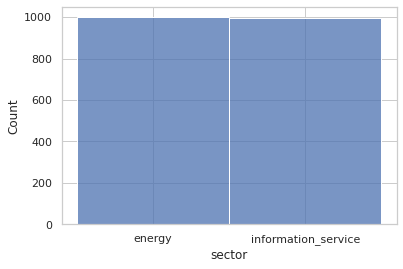

In [12]:
print('There are {} sectors values'.format(data.sector.nunique()))
print(set(data.sector))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.histplot(x="sector", data=data)
plt.show();

They are exactly the same number

There are 3 countries values
{'CountryB', 'CountryC', 'CountryA'}


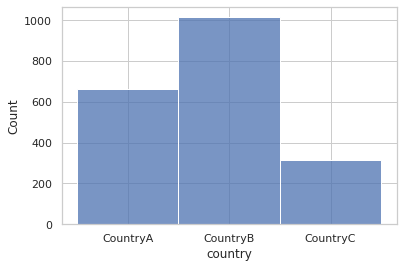

In [13]:
print('There are {} countries values'.format(data.country.nunique()))
print(set(data.country))
ax = sns.histplot(x="country", data=data)
plt.show();

Heterogeneous distribution.

### Contunuous features

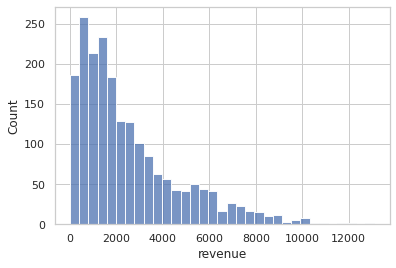

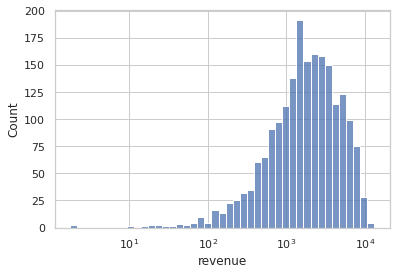

In [14]:
ax = sns.histplot(x="revenue", data=data)
plt.show();
ax = sns.histplot(x="revenue", data=data,log_scale=True)
plt.show();

Almost power low. The biggest data are pretty sparse.

Less information foir big data. We expect less precision.

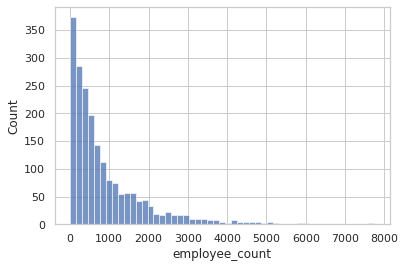

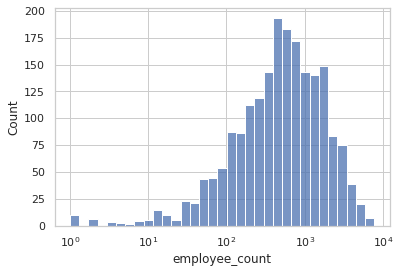

In [15]:
ax = sns.histplot(x="employee_count", data=data)
plt.show();
ax = sns.histplot(x="employee_count", data=data[['revenue','employee_count']]+1,log_scale=True)
plt.show();

In [16]:
a = sum(data['employee_count']==0)
a

10

There are 10 companies that are 0.

Talked to Dominic: most probably, missing data. Not more information about it. I'll treat them as missing data.

### Target feature

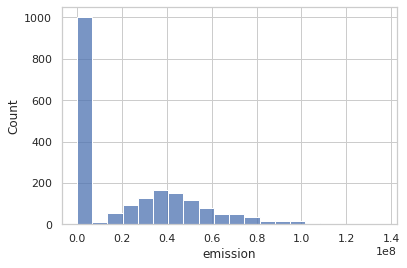

In [17]:
ax = sns.histplot(x="emission", data=data)
plt.show();

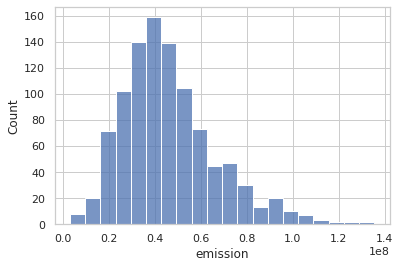

In [18]:
big_val = data[data['emission']>0.10e6]
ax = sns.histplot(x="emission", data=big_val,bins=20,log_scale=False)
plt.show();

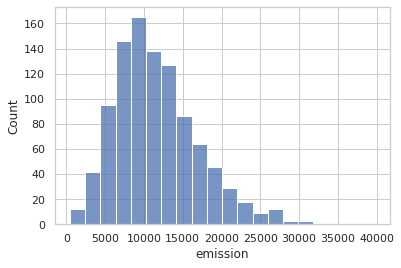

In [19]:
small_val = data[data['emission']<0.10e6]
ax = sns.histplot(x="emission", data=small_val,bins=20,log_scale=False)
plt.show();

There are two different "normal" distribution:

one around $4 \cdot 10^7$

the second around $10 \cdot 10^5$

Probably due to how there were created

## Correlations

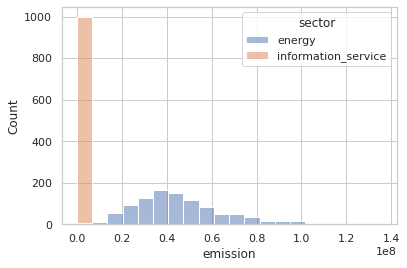

In [88]:
ax = sns.histplot(x="emission",hue='sector', data=data,bins=20,log_scale=False)
plt.show();

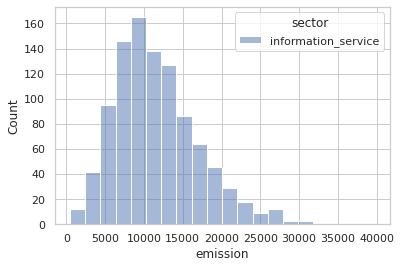

In [97]:
ax = sns.histplot(x="emission",hue='sector', data=small_val,bins=20,log_scale=False)
plt.show();

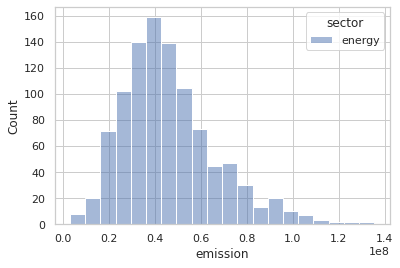

In [20]:
ax = sns.histplot(x="emission",hue='sector', data=big_val,bins=20,log_scale=False)
plt.show();

The two sectors are perfectly divided.

We can treat them as two different dataset.

#### Countries - Emissions

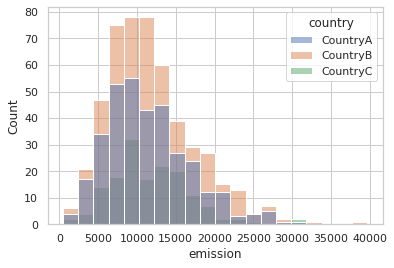

In [23]:
# Energy sector
ax = sns.histplot(x="emission",hue='country', data=small_val,bins=20,log_scale=False)
plt.show();

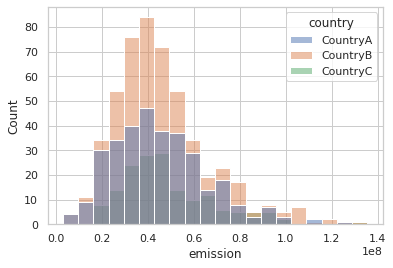

In [24]:
# information_service sector
ax = sns.histplot(x="emission",hue='country', data=big_val,bins=20,log_scale=False)
plt.show();

Country homogeneusly distributed over the emissions values

In [ ]:
# ax = sns.histplot(x="revenue",hue='sector', data=data,bins=20,log_scale=False)
# plt.show();
# ax = sns.histplot(x="revenue",hue='country', data=data,bins=20,log_scale=False)
# plt.show();

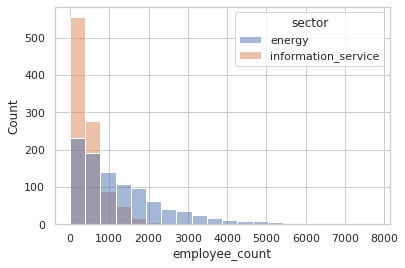

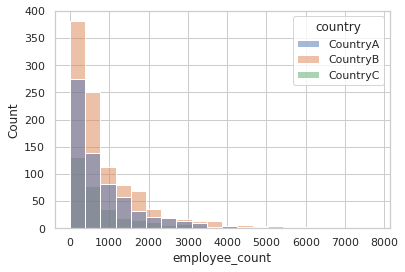

In [100]:
# Replace missing values
ax = sns.histplot(x="employee_count",hue='sector', data=data,bins=20,log_scale=False)
plt.show();
ax = sns.histplot(x="employee_count",hue='country', data=data,bins=20,log_scale=False)
plt.show();

Small data missing for employee_count, otherwise model to replace based on average on sector (strong correlation)

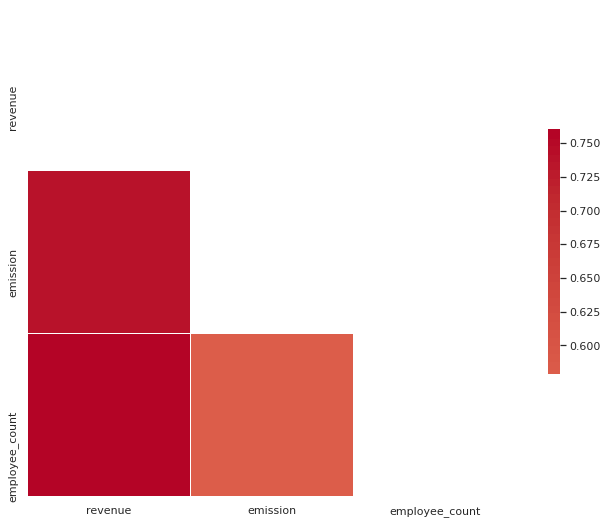

In [22]:
corr_num = data.select_dtypes(include=['int64','float64'])
# Compute the correlation matrix
corr = corr_num.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = 'coolwarm'#sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As expected the correlations are petty high: bigger emissions implies bigger revenue and employee number

In [117]:
# # Fit on all the data without validation and predict a dataset
# pipe_baseline.fit(X,y)
# y_pred_baseline = pipe_baseline.predict(X_no_target)
# y_pred_baseline[:5]

array([15056.82819973, 13671.26183492])

In [109]:
# Null values only in employee_count
for col in data.columns:
    print(col,sum(data[col]==0))

revenue 0
emission 0
employee_count 10
sector 0
country 0


## Model iterations

In [30]:
# Preprocessing pipeline
preproc_numerical = make_pipeline(
    SimpleImputer(missing_values=0,strategy="mean"),
    MinMaxScaler())

preproc_categorical = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"))

preproc = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical, make_column_selector(dtype_include=["object"])),
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(missing_values=0)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4c8b162220>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4c8b162a00>)])

### Linear Models (Lasso, Ridge, ElasticNet, SGDRegressor...)

In [32]:
score_baseline

10688374.096997617

In [50]:
def comp_scores(score):
    print('score: {}'.format(score),
          'compared to baseline: {}'.format(score / score_baseline))
    return None

In [51]:
# LinearRegression
model = LinearRegression()
pipe_LR = make_pipeline(preproc, model)
score_LR = cross_val_score(pipe_LR, X, y, cv=5, scoring=rmse).mean()

comp_scores(score_LR)

score: 10688249.499571033 compared to baseline: 0.999988342714668


### KNN

In [41]:
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)

In [52]:
scores = cross_val_score(pipe_knn, X, y, cv=5, scoring=rmse)
score_knn = scores.mean()
comp_scores(score_knn)

score: 9559281.748310741 compared to baseline: 0.8943625720394611


### SVM

In [53]:
model = SVR(kernel='linear')
pipe_svm = make_pipeline(preproc, model)
score_lin_SVR = cross_val_score(pipe_svm, X, y, cv=5, scoring=rmse).mean()
comp_scores(score_lin_SVR)

score: 38757944.127787955 compared to baseline: 3.62617773068732


In [54]:
model = SVR(kernel='rbf', C = 10)
pipe_svm_rbf = make_pipeline(preproc, model)
score_SVR = cross_val_score(pipe_svm_rbf, X, y, cv=5, scoring=rmse).mean()
comp_scores(score_SVR)

score: 38755163.35652134 compared to baseline: 3.625917562841268


### Trees

In [55]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
pipe = make_pipeline(preproc, model)
score = cross_val_score(pipe, X, y, cv=5, scoring=rmse)
print(score.std())
score_trees = score.mean()
comp_scores(score_trees)

7697089.606813667
score: 9288161.857964179 compared to baseline: 0.8689967036776192


### Random Forests

In [56]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)
pipe = make_pipeline(preproc, model)
score = cross_val_score(pipe, X, y, cv=5, scoring=rmse)
print(score.std())
score_rf = score.mean()
comp_scores(score_rf)

7509352.537144539
score: 9061472.693161117 compared to baseline: 0.8477877562038646


### Boosted Trees

In [57]:
model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model)
score = cross_val_score(pipe, X, y, cv=5, scoring=rmse)
print(score.std())
score_AdaBR = score.mean()
comp_scores(score_AdaBR)

8258942.96555123
score: 10829733.760396672 compared to baseline: 1.0132255534954342


GradientBoostingRegressor, XGBRegressor, XGBRegressor, etc...

In [59]:
# For the grid-search
rmse_neg = make_scorer(lambda y_true, y_pred: -1*mean_squared_error(y_true, y_pred)**0.5)

In [63]:
# GridSearch the KNN
if allow_grid_searching:
    param_grid =  {'kneighborsregressor__n_neighbors': [15,20,30,40,50,70]}
    search_knn = GridSearchCV(pipe_knn, param_grid=param_grid, 
                              cv=3, verbose=0, scoring=rmse_neg)

    search_knn.fit(X, y);
    print(search_knn.best_params_)
    search_knn.best_score_

{'kneighborsregressor__n_neighbors': 30}


In [65]:
model = KNeighborsRegressor(n_neighbors=30)
pipe_knn = make_pipeline(preproc, model)

scores = cross_val_score(pipe_knn, X, y, cv=5, scoring=rmse)
score_knn = scores.mean()
comp_scores(score_knn)

score: 9059290.563435202 compared to baseline: 0.8475835970206145


instead of $0.89$

In [75]:
# X = data.drop(columns=['emissions'])
# y = data['emissions']
# X.shape
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42)

In [76]:
# Fit on all the data without validation and predict a dataset
pipe_knn.fit(X_train,y_train)
y_pred = pipe_knn.predict(X_test)

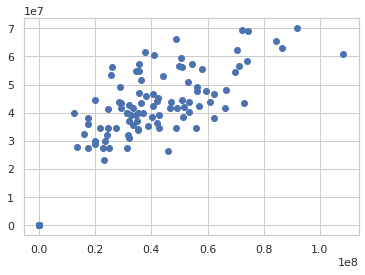

In [78]:
plt.scatter(y_test,y_pred)
plt.plot(((0,0),(1,1)))

# Still to do

## Compare the

## I would have tried some grid-searching

## Let's divide the dataset in two:
### 1) sector: energy
### 2) sector: information_service

#### !! Caution !! We can do this only if we know that the sector information is always available!
#### If new sectors are available, always use a model that comprehend them both

In [112]:
data_en = data[data['sector']=='energy']
data_it = data[data['sector']=='information_service']